In [1]:
%load_ext autoreload
import os,sys
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import progressbar
from datetime import datetime
sys.path.append("../")

print(sys.path)

%autoreload 2
from src.pySRM.pysrm.segment import IMZMLExtract, SpectraRegion, ProteinWeights, CombinedSpectra
from collections import Counter, defaultdict


['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/rita/.local/lib/python3.6/site-packages', '/home/rita/.local/lib/python3.6/site-packages/SimpleITK-1.2.0rc2.dev1162+g2a79d-py3.6-linux-x86_64.egg', '/home/rita/.local/lib/python3.6/site-packages/imreg_dft-2.0.1a0-py3.6.egg', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/tf_unet-0.1.1-py3.6.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/rita/.ipython', '../']


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
#! ls /mnt/f/dev/data/msi/AL1_1

ls: cannot access '/mnt/f/dev/data/msi/AL1_1': No such file or directory


In [2]:
#imze = IMZMLExtract("/mnt/f/dev/data/msi/AL1_1/200213_AL1_1.imzML")
imze = IMZMLExtract("/usr/local/hdd/shibo/lipids/AL1_1/200213_AL1_1.imzML")

Opening regions file for /usr/local/hdd/shibo/lipids/AL1_1/200213_AL1_1.imzML


0 ((4449, 4505, 938, 1002), 3705)
1 ((4490, 4532, 1365, 1415), 2180)
2 ((3542, 3644, 1195, 1262), 7004)
3 ((2409, 2502, 1572, 1633), 5828)
4 ((4559, 4646, 1158, 1250), 8158)
5 ((2317, 2372, 1400, 1490), 5096)
6 ((2317, 2387, 1648, 1702), 3905)


<Figure size 1440x576 with 0 Axes>

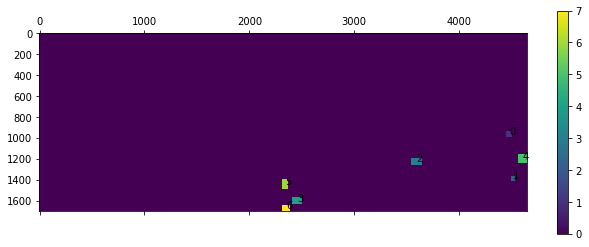

{0: ((4449, 4505, 938, 1002), 3705),
 1: ((4490, 4532, 1365, 1415), 2180),
 2: ((3542, 3644, 1195, 1262), 7004),
 3: ((2409, 2502, 1572, 1633), 5828),
 4: ((4559, 4646, 1158, 1250), 8158),
 5: ((2317, 2372, 1400, 1490), 5096),
 6: ((2317, 2387, 1648, 1702), 3905)}

In [3]:
plt.figure(figsize=(20, 8))
imze.list_regions()

In [5]:
#avg_region_spectrum = imze.get_avg_region_spectrum(2)

In [4]:
maxShift = 20
spectra_orig = imze.get_region_array(3, makeNullLine=True)
sh_sporig_bg, sh_masses_sporig_bg = imze.shift_region_array(spectra_orig, imze.mzValues, maxShift)

Found region 3 with shape (94, 62, 38800)
I0920 16:27:49.212486 139676059379520 segment.py:2916] Found region 3 with shape (94, 62, 38800)
100% |########################################################################|


Shifts: mean: -1.4826698695950584, median: -1.0


In [5]:
def plot_coords(arr, coords, valRange, xvals):
    plt.figure(figsize=(20, 6))
        
    for x in coords:
        plt.plot(xvals[valRange], arr[x[0], x[1]][valRange], label=str(x))
    plt.legend()

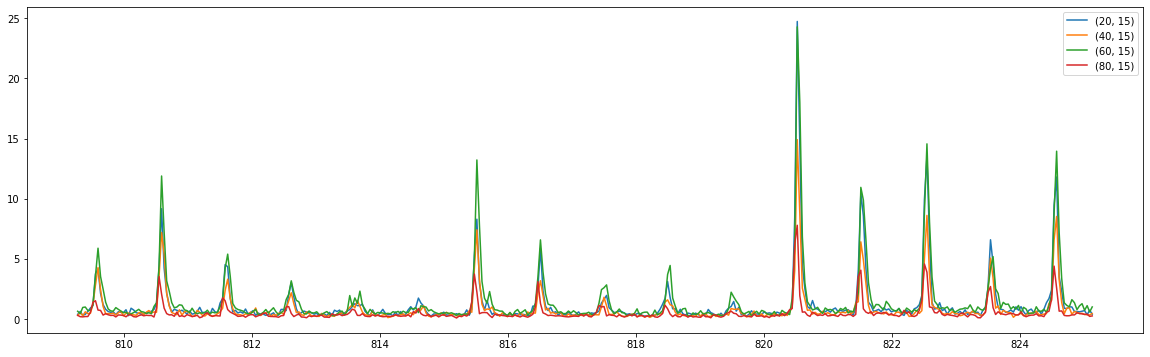

In [6]:
plot_coords(spectra_orig, [(20,15), (40,15), (60,15), (80,15)], range(8800,9200), imze.mzValues)

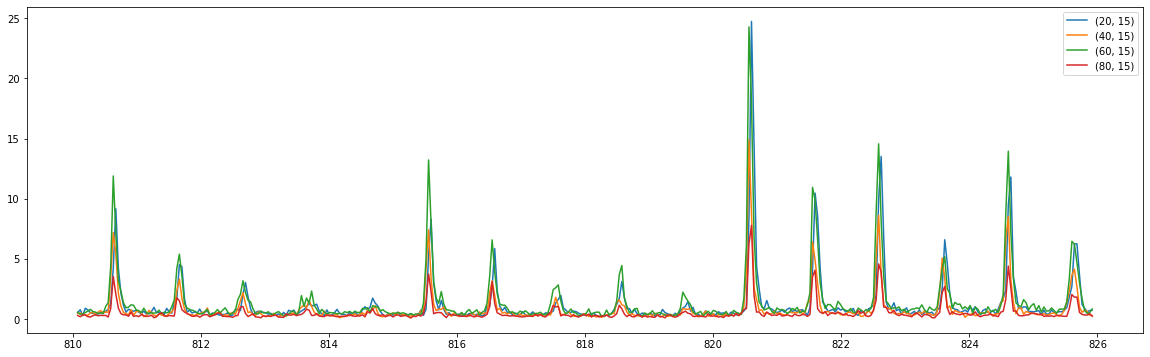

In [7]:
plot_coords(sh_sporig_bg, [(20,15), (40,15), (60,15), (80,15)], range(8800,9200), sh_masses_sporig_bg)

The shifted peaks seem to match better, and are optimized for cosine similarity.

In [9]:
#spectra_intra = imze.normalize_region_array(spectra_orig, normalize="intra_median")

In [6]:
#spectra_orig_nobg, spectra_orig_nobg_masses = imze.remove_background_spec_aligned(spectra_orig,avg_region_spectrum, imze.mzValues, 20)
#sh_sporig, sh_masses_sporig = imze.shift_region_array(spectra_orig_nobg, spectra_orig_nobg_masses, maxShift)

In [10]:
#sh_sporig_bg = imze.normalize_region_array(spectra_intra, normalize="inter_median")

In [11]:
#spectra_intra_inter_max = imze.normalize_region_array(sh_sporig_bg,normalize="max_intensity_spectrum")

In [8]:
sh_sporig_bg_norm = imze.normalize_region_array(sh_sporig_bg, normalize="vector")

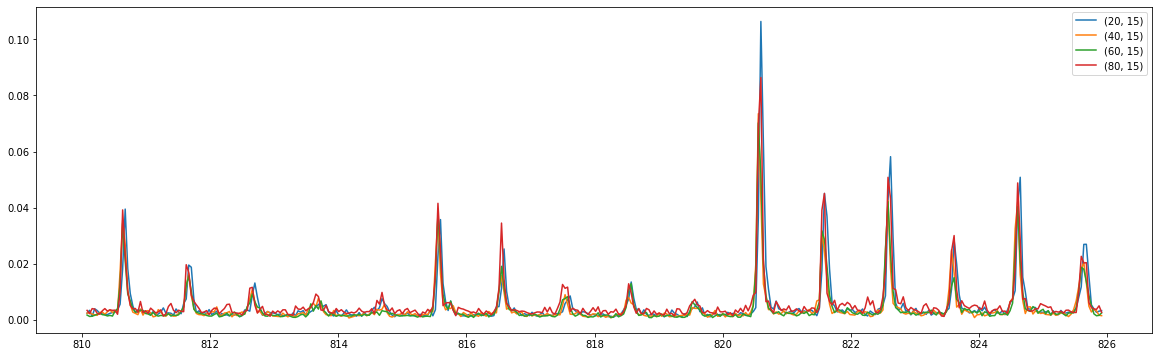

In [9]:
plot_coords(sh_sporig_bg_norm, [(20,15), (40,15), (60,15), (80,15)], range(8800,9200), sh_masses_sporig_bg)

Keep a copy of the originally normalized spectrum

In [10]:
spectra = np.array(sh_sporig_bg_norm, copy=True)

This function calculates a diagonal (width 5) from top to bottom. The idea is, that if there is a target region and background in a MSI dataset, it will be included in this band

In [11]:
def calc_band_pixels(spre):
    
    band_pixels = set()
    
    xmax = spre.shape[0]
    ymax = spre.shape[1]
    
    p2 = np.array([xmax, ymax])
    p1 = np.array([0,0])
    
    for i in range(spre.shape[0]):
        for j in range(spre.shape[1]):
            
            p3 = np.array([i,j])
            d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            
            if d < 2:
                band_pixels.add((i,j))
                
    return band_pixels
    

This function calculates the differential masses for each spectrum comparison. Each spectrum from a testPixel is compared against each testAgainstPixel.

In [12]:

def calculateDiffMasses( inSpectra, testPixels, testAgainstPixels, storeFCs = False):

    global_fcs = Counter()
    scalingFactor = 1000

    fcMassesCounter = Counter()
    masses2fcs = defaultdict(list)

    stdMul = 8

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])

    for (k,l) in bar(testPixels):       
        
        for i in range(inSpectra.shape[0]):
            for j in range(inSpectra.shape[1]):

                if (k,l) == (i,j):
                    continue

                if not (i,j) in testAgainstPixels:
                    continue


                fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)

                maxFC = meanFCs + stdMul*stdFCs
                minFC = meanFCs - stdMul*stdFCs

                if len(fcMassesCounter) > 0 and len(fcMassesCounter) % 1000 == 0:
                    print("Masses: ", len(fcMassesCounter))

                for ifc, x in enumerate(fcs):                        
                    if x < minFC or x > maxFC:
                        fcMass = imze.mzValues[ifc]
                        fcMassesCounter[fcMass] += 1
         
    print("Found", len(fcMassesCounter), "differential masses")
        
    if storeFCs:
        bar = progressbar.ProgressBar(widgets=[
                progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
            ])

        
        for (k,l) in bar(testPixels):       

            for i in range(inSpectra.shape[0]):
                for j in range(inSpectra.shape[1]):

                    if (k,l) == (i,j):
                        continue

                    if not (i,j) in testAgainstPixels:
                        continue


                    fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)

                    maxFC = meanFCs + stdMul*stdFCs
                    minFC = meanFCs - stdMul*stdFCs

                    for ifc, x in enumerate(fcs):

                        fcMass = imze.mzValues[ifc]

                        if fcMass in fcMassesCounter:
                            masses2fcs[fcMass].append(x)                      


    return fcMassesCounter, masses2fcs

                

In [83]:
import imageio
from sklearn import tree
from skimage.color import rgb2gray,rgba2rgb

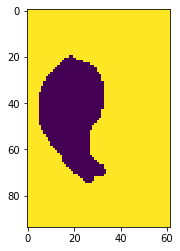

In [84]:
manual_mask = np.round(rgb2gray(rgba2rgb(imageio.imread("aorta_test_lipids.png"))))
plt.imshow(manual_mask)

The manual mask contains a mask for the target region which we want to at least somehow separate.

In [85]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import random

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [86]:
spec_subset_de = SpectraRegion(spectra, sh_masses_sporig_bg, "mass_shift_unitnorm")

We now want to find all shape == aorta pixels, and all background ones

In [87]:
shapePixels = set()
bgPixels = set()

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        if manual_mask[x,y] < 0.5:
            shapePixels.add((x,y))
        else:
            bgPixels.add((x,y))

In [88]:
print("Included pixels", len(shapePixels), len(bgPixels))

testPixels_aorta = random.sample(shapePixels, 100)
testPixels_bg = random.sample(bgPixels, 100)

Included pixels 1059 4769


In [89]:

values_train = []
classes_train = []

values_test = []
classes_test = []

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        if (x,y) in testPixels_aorta:
            values_test.append(spectra[x,y,:])
            classes_test.append(1)
            continue           
        if (x,y) in testPixels_bg:
            values_test.append(spectra[x,y,:])
            classes_test.append(0)
            continue
        
        if manual_mask[x,y] >= 0.5:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(0)
            
        else:
            
            values_train.append(spectra[x,y,:])
            classes_train.append(1)
        
        
print("Train size", len(values_train))
print("Test size", len(values_test))

Train size 5628
Test size 200


In [92]:
subsetIdx = random.sample([x for x in range(0, len(values_train))], 600)
#subsetIdx = [x for x in range(0, len(values_train))]

values_train_sub = []
classes_train_sub = []

for sIdx in subsetIdx:
    values_train_sub.append( values_train[sIdx] )
    classes_train_sub.append( classes_train[sIdx] )
    
print("Subsetted", len(values_train_sub))

Subsetted 600


In [93]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display# load dataset


Now learn and evaluate the testPixels

In [145]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(values_train_sub, classes_train_sub)

In [146]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [147]:
np.unique(clf.feature_importances_)

array([0.        , 0.01696684, 0.06780019, 0.09593942, 0.10424036,
       0.12047238, 0.16105673, 0.43352409])

In [166]:
np.where(clf.feature_importances_>0)[0]

array([ 3943,  7075,  9065, 19569, 27768, 30179, 36352])

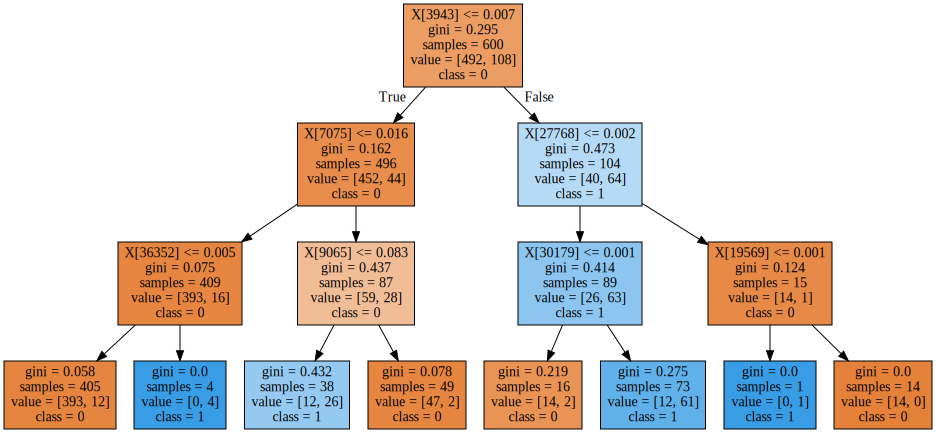

In [162]:
graph = Source(tree.export_graphviz(clf, out_file=None
   , class_names=['0', '1'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

In [150]:
prediction_image = np.zeros(manual_mask.shape)
for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        retVal = clf.predict_proba([ spectra[x,y,:] ])[0]
        pred_label = np.argmax(retVal)
        if pred_label == 1:
            prediction_image[x,y] = 0
        else:
            prediction_image[x,y] = 1

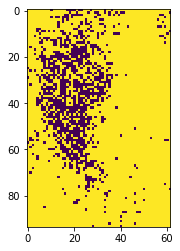

In [151]:
plt.imshow(prediction_image)

In [152]:
np.where(clf.feature_importances_>0)[0]

array([ 3943,  7075,  9065, 19569, 27768, 30179, 36352])

In [154]:
def eval_mass(mass, max_intens, spectra, predicted, manual):
    
    correct = 0
    wrong = 0

    for x in range(0, spectra.shape[0]):
        for y in range(0, spectra.shape[1]):
            if spectra[x,y,mass] < max_intens:
                if predicted[x,y] == manual[x,y]:
                    correct += 1 
                else:
                    wrong += 1
                    
    correct /= (spectra.shape[0]*spectra.shape[1])
    wrong /= (spectra.shape[0]*spectra.shape[1])
    return correct, wrong
        

In [164]:
eval_mass(mass=3943, max_intens=0.007, spectra=spectra, predicted=prediction_image, manual=manual_mask)

(0.7693891557995882, 0.08870967741935484)

In [156]:
eval_mass(7075, 0.016, spectra, prediction_image, manual_mask)

(0.6897735072065889, 0.07618393960192175)

In [157]:
eval_mass(9065, 0.083, spectra, prediction_image, manual_mask)

(0.33236101578586136, 0.09231297185998627)

In [158]:
eval_mass(19569, 0.001, spectra, prediction_image, manual_mask)

(0.34248455730954014, 0.07240905971173645)

In [159]:
eval_mass(27768, 0.002, spectra, prediction_image, manual_mask)

(0.5403225806451613, 0.10706932052161977)

In [160]:
eval_mass(30179, 0.001, spectra, prediction_image, manual_mask)

(0.39121482498284144, 0.07824296499656828)

In [161]:
eval_mass(36352, 0.005, spectra, prediction_image, manual_mask)

(0.841283459162663, 0.1448181194234729)

2020-09-20 18:01:28,572  SpectraRegion  INFO: Processing Mass 617.244532135695 with best existing mass 617.244532135695
I0920 18:01:28.572957 139676059379520 segment.py:787] Processing Mass 617.244532135695 with best existing mass 617.244532135695


3943 617.244532135695


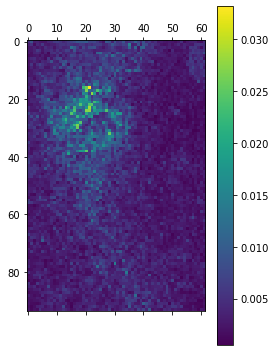

2020-09-20 18:01:28,736  SpectraRegion  INFO: Processing Mass 741.5908436777291 with best existing mass 741.5908436777291
I0920 18:01:28.736206 139676059379520 segment.py:787] Processing Mass 741.5908436777291 with best existing mass 741.5908436777291


7075 741.5908436777291


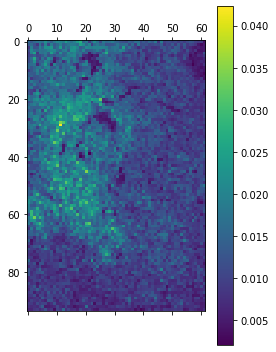

2020-09-20 18:01:28,892  SpectraRegion  INFO: Processing Mass 820.5975997341302 with best existing mass 820.5975997341302
I0920 18:01:28.892346 139676059379520 segment.py:787] Processing Mass 820.5975997341302 with best existing mass 820.5975997341302


9065 820.5975997341302


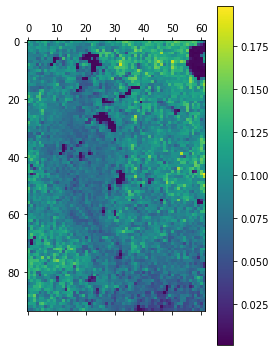

2020-09-20 18:01:29,047  SpectraRegion  INFO: Processing Mass 1237.6262256720377 with best existing mass 1237.6262256720377
I0920 18:01:29.047942 139676059379520 segment.py:787] Processing Mass 1237.6262256720377 with best existing mass 1237.6262256720377


19569 1237.6262256720377


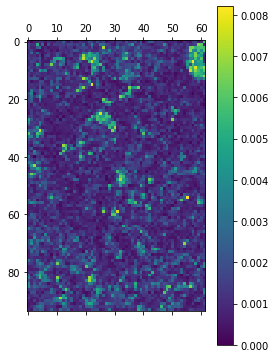

2020-09-20 18:01:29,208  SpectraRegion  INFO: Processing Mass 1563.142001001903 with best existing mass 1563.142001001903
I0920 18:01:29.208757 139676059379520 segment.py:787] Processing Mass 1563.142001001903 with best existing mass 1563.142001001903


27768 1563.142001001903


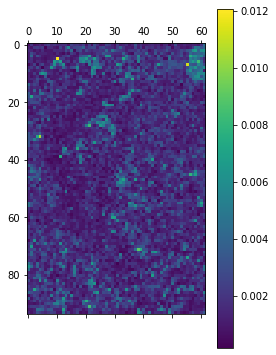

2020-09-20 18:01:29,360  SpectraRegion  INFO: Processing Mass 1658.8632516812913 with best existing mass 1658.8632516812913
I0920 18:01:29.360861 139676059379520 segment.py:787] Processing Mass 1658.8632516812913 with best existing mass 1658.8632516812913


30179 1658.8632516812913


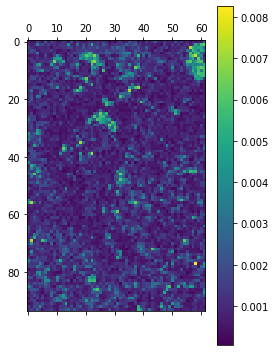

2020-09-20 18:01:29,519  SpectraRegion  INFO: Processing Mass 1903.9430030059966 with best existing mass 1903.9430030059966
I0920 18:01:29.519701 139676059379520 segment.py:787] Processing Mass 1903.9430030059966 with best existing mass 1903.9430030059966


36352 1903.9430030059966


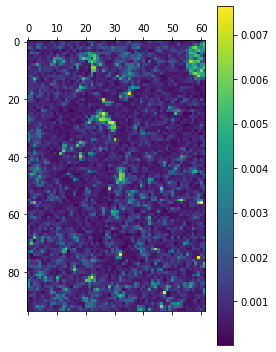

In [167]:
treeMasses = set()
for mzIdx in np.where(clf.feature_importances_>0)[0]:#[7075, 7127, 9669, 3943,38355,22087,13099]:
    mzVal = spec_subset_de.idx2mass[mzIdx]
    
    print(mzIdx, mzVal)
    treeMasses.add(mzVal)
    spec_subset_de.mass_heatmap(mzVal)

2020-09-20 12:18:00,358  SpectraRegion  INFO: Processing Mass 567.537769 with best existing mass 567.5377690288537
I0920 12:18:00.358004 140029347829568 segment.py:787] Processing Mass 567.537769 with best existing mass 567.5377690288537


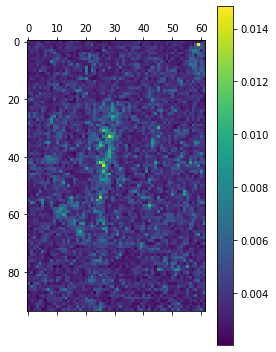

array([[0.00344985, 0.00324801, 0.0028085 , ..., 0.00267613, 0.00300838,
        0.0050018 ],
       [0.00286183, 0.00308056, 0.00304856, ..., 0.01483726, 0.00623213,
        0.00426812],
       [0.00426916, 0.00303902, 0.00399362, ..., 0.00552902, 0.00571967,
        0.00456325],
       ...,
       [0.0027828 , 0.00304045, 0.00325934, ..., 0.00319564, 0.00241548,
        0.00388934],
       [0.00337631, 0.0023731 , 0.00307563, ..., 0.00462559, 0.00312022,
        0.00355237],
       [0.00354674, 0.00257055, 0.00341091, ..., 0.00444735, 0.00658037,
        0.00290475]])

In [42]:
spec_subset_de.mass_heatmap(567.537769)

In [106]:
trueRate = 0
for value, label in zip(values_test, classes_test):
    retVal = clf.predict_proba([value])[0]
    pred_label = np.argmax(retVal)
    #print(label, pred_label, label==pred_label)
    
    if label==pred_label:
        trueRate += 1
        
print(trueRate, trueRate / len(classes_test))

142 0.71


Given the ok-ish true positive rate, let's check what that means for the full image:

831 5828 0.14258750857927247


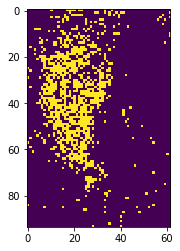

In [107]:
trues = np.zeros((spectra.shape[0], spectra.shape[1]))

trueEvals = 0

for x in range(0, spectra.shape[0]):
    for y in range(0, spectra.shape[1]):
        
        
        retVal = clf.predict_proba([ spectra[x,y,:] ])[0]
        pred_label = np.argmax(retVal)
        
        if pred_label == 1:
            trues[x,y] = 1
            
        if pred_label == manual_mask[x,y]:
            trueEvals += 1
            
print(trueEvals, spectra.shape[0]*spectra.shape[1], trueEvals / (spectra.shape[0]*spectra.shape[1]))
plt.imshow(trues)
        

That does not look too bad. Apparently it is possible to learn the difference.

Now we want to reproduce this using an unsupervised approach ...

This will calculate all differential masses for 300 shape/Aorta pixels against background pixels on the diagonal

In [53]:
bandPixels = calc_band_pixels(spectra)
bandPixels = set(bandPixels).difference(shapePixels)

testShape = random.sample(shapePixels, 300)

masses_de, masses_counter_de = calculateDiffMasses( spectra, testShape, bandPixels, storeFCs=False)

|#########################################################| 100% Time:  0:08:36


Found 309 differential masses


In [51]:
masses_aorta, masses_counter_aorta = calculateDiffMasses( spectra, testShape , testShape, storeFCs=False)

|#########################################################| 100% Time:  0:08:30


Found 241 differential masses


In [52]:
testBg = random.sample(bgPixels, 300)

masses_bg, masses_counter_bg = calculateDiffMasses( spectra, testBg , testBg, storeFCs=False)

|#########################################################| 100% Time:  0:08:10


Found 266 differential masses


Given these results, the masses we are interested in are those found by masses_de, which are not in either masses_aorta or masses_bg .

In [79]:
fcMasses = Counter()

for x in masses_de:
    fcMasses[x] = masses_de[x]
    
print(len(fcMasses), fcMasses.most_common(5))

309 [(698.6731033274932, 4687), (698.7128052149587, 4671), (742.6627946392985, 4627), (830.7612829253053, 4614), (654.683412015688, 4577)]


2020-08-19 13:09:45,671  SpectraRegion  INFO: Processing Mass 698.6731033274932 with best existing mass 698.6731033274932


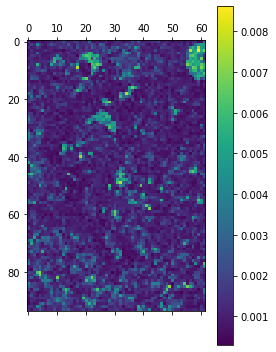

2020-08-19 13:09:45,784  SpectraRegion  INFO: Processing Mass 698.7128052149587 with best existing mass 698.7128052149587


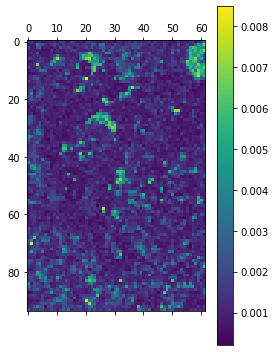

2020-08-19 13:09:45,893  SpectraRegion  INFO: Processing Mass 742.6627946392985 with best existing mass 742.6627946392985


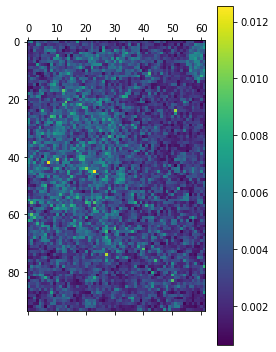

2020-08-19 13:09:46,122  SpectraRegion  INFO: Processing Mass 830.7612829253053 with best existing mass 830.7612829253053


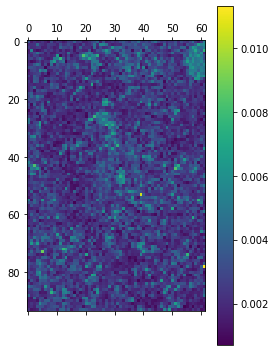

2020-08-19 13:09:46,232  SpectraRegion  INFO: Processing Mass 654.683412015688 with best existing mass 654.683412015688


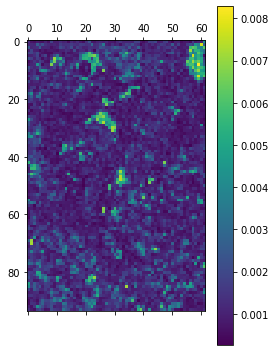

In [92]:
for x,y in fcMasses.most_common(5):
    spec_subset_de.mass_heatmap(x)

In [55]:
deMasses = set([x for x in masses_de])
aortaMasses = set([x for x in masses_aorta])
bgMasses = set([x for x in masses_bg])

In [67]:
validMasses = deMasses.difference(aortaMasses).difference(bgMasses)

In [68]:
fcMassesValid = Counter()

for x in masses_de:
    if x in validMasses:
        fcMassesValid[x] = masses_de[x]
        
print(len(fcMassesValid), fcMassesValid.most_common(5))

40 [(858.8305173634337, 27), (771.8039800389961, 25), (699.7847561765279, 24), (963.8420097097556, 23), (612.5994113022282, 21)]


NameError: name 'fcMassesValid' is not defined

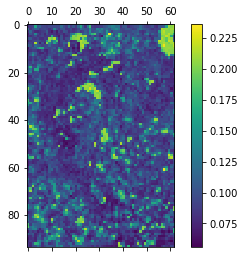

In [87]:
sc = spec_subset_de.plot_tic([x[0] for x in fcMassesValid.most_common()])

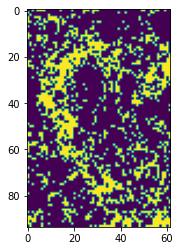

In [94]:
plt.imshow(sc < 0.085)

2020-08-19 12:11:48,213  SpectraRegion  INFO: Processing Mass 858.8305173634337 with best existing mass 858.8305173634337


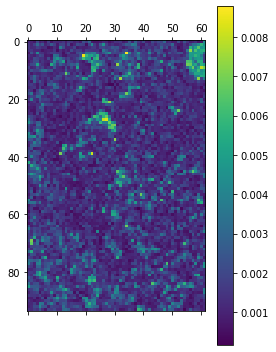

2020-08-19 12:11:48,323  SpectraRegion  INFO: Processing Mass 771.8039800389961 with best existing mass 771.8039800389961


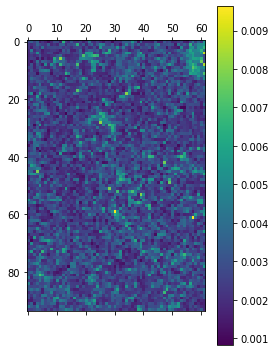

2020-08-19 12:11:48,435  SpectraRegion  INFO: Processing Mass 699.7847561765279 with best existing mass 699.7847561765279


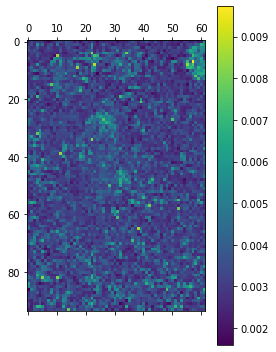

2020-08-19 12:11:48,543  SpectraRegion  INFO: Processing Mass 963.8420097097556 with best existing mass 963.8420097097556


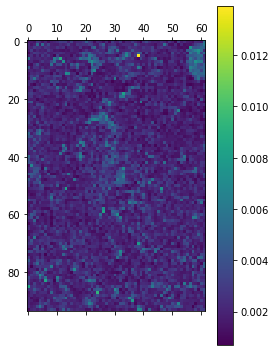

2020-08-19 12:11:48,648  SpectraRegion  INFO: Processing Mass 612.5994113022282 with best existing mass 612.5994113022282


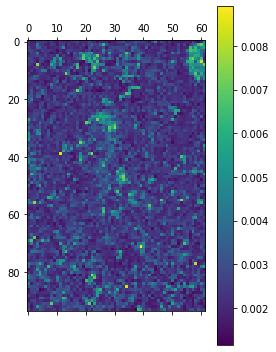

2020-08-19 12:11:48,913  SpectraRegion  INFO: Processing Mass 962.8891644105829 with best existing mass 962.8891644105829


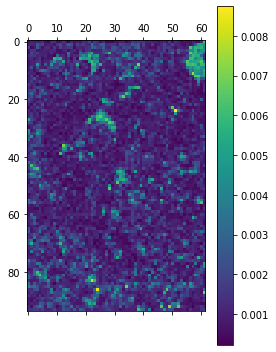

2020-08-19 12:11:49,023  SpectraRegion  INFO: Processing Mass 787.803840687604 with best existing mass 787.803840687604


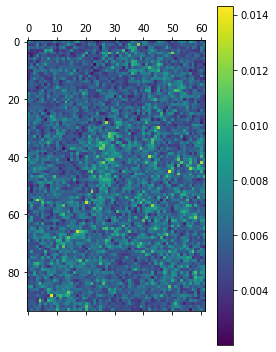

2020-08-19 12:11:49,130  SpectraRegion  INFO: Processing Mass 682.7923483412819 with best existing mass 682.7923483412819


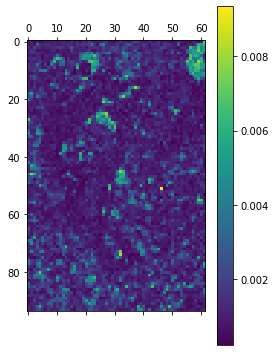

2020-08-19 12:11:49,235  SpectraRegion  INFO: Processing Mass 740.836507815884 with best existing mass 740.836507815884


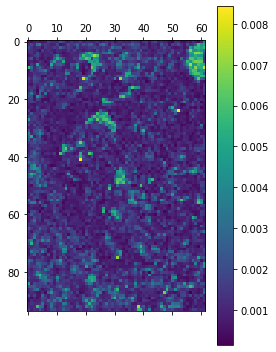

2020-08-19 12:11:49,349  SpectraRegion  INFO: Processing Mass 798.8012635155551 with best existing mass 798.8012635155551


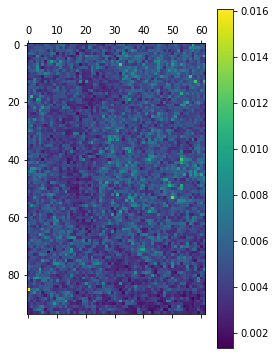

In [102]:
for x,y in fcMassesValid.most_common(10):
    mi = spec_subset_de.mass_heatmap(x)

What can be seen is that this does not work very well ...

In [143]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in treeMasses])
sub_peaks_count = Counter()
for x in fcMasses:
    sub_peaks_count[x] = masses_de[x]

sub_peaks_de = spectra[:,:,fcIndices]
sub_masses_de = imze.mzValues[fcIndices]

In [144]:
spec_subset_only_relevant = SpectraRegion(sub_peaks_de, sub_masses_de)

In [146]:
spec_subset_only_relevant.calculate_similarity(mode="spectra_log_dist")

2020-08-19 13:35:47,705  SpectraRegion  INFO: Creating C++ obj
2020-08-19 13:35:47,706  SpectraRegion  INFO: 7 (94, 62, 7)
2020-08-19 13:35:47,707  SpectraRegion  INFO: dimensions 7
2020-08-19 13:35:47,707  SpectraRegion  INFO: input dimensions (94, 62, 7)
2020-08-19 13:35:47,708  SpectraRegion  INFO: Switching to dot mode
2020-08-19 13:35:47,708  SpectraRegion  INFO: Starting calc similarity c++
2020-08-19 13:35:47,874  SpectraRegion  INFO: outclust dimensions (5828, 5828)
2020-08-19 13:35:47,875  SpectraRegion  INFO: Calculating spectra similarity


7


2020-08-19 13:35:48,006  SpectraRegion  INFO: Calculating spectra similarity done
2020-08-19 13:35:48,007  SpectraRegion  INFO: Calculating dist pixel map
2020-08-19 13:38:39,424  SpectraRegion  INFO: Calculating dist pixel map done


array([[0.94999999, 0.93892231, 0.94633029, ..., 0.98403563, 0.98619813,
        0.98360603],
       [0.93892231, 0.94999999, 0.92155536, ..., 0.98343369, 0.98971494,
        0.98162895],
       [0.94633029, 0.92155536, 0.94999999, ..., 0.9786424 , 0.97611251,
        0.97851141],
       ...,
       [0.98403563, 0.98343369, 0.9786424 , ..., 0.94999999, 0.94383194,
        0.949733  ],
       [0.98619813, 0.98971494, 0.97611251, ..., 0.94383194, 0.94999999,
        0.94049772],
       [0.98360603, 0.98162895, 0.97851141, ..., 0.949733  , 0.94049772,
        0.94999999]])

In [147]:
spec_subset_only_relevant.segment(method="WARD", number_of_regions=3)

2020-08-19 13:38:39,539  SpectraRegion  INFO: Calculating clusters
2020-08-19 13:38:40,122  SpectraRegion  INFO: Calculating clusters done
2020-08-19 13:38:40,134  SpectraRegion  INFO: Calculating clusters saved


array([[2, 3, 2, ..., 2, 2, 1],
       [2, 3, 2, ..., 1, 1, 1],
       [3, 2, 3, ..., 1, 1, 1],
       ...,
       [2, 2, 3, ..., 2, 2, 3],
       [2, 2, 3, ..., 3, 1, 3],
       [2, 2, 3, ..., 3, 3, 2]], dtype=int16)

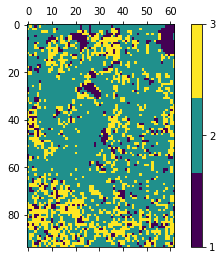

In [148]:
spec_subset_only_relevant.plot_segments()

2020-08-19 13:41:58,057  SpectraRegion  INFO: Calculating clusters
2020-08-19 13:41:58,214  SpectraRegion  INFO: UMAP reduction


Elem Matrix (5828, 5)


2020-08-19 13:42:08,737  SpectraRegion  INFO: HDBSCAN reduction


(5828, 2)
(16979878,)


2020-08-19 13:42:09,168  SpectraRegion  INFO: Calculating clusters done
2020-08-19 13:42:09,180  SpectraRegion  INFO: Calculating clusters saved


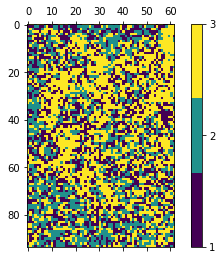

In [156]:
spec_subset_only_relevant.segment(method="UMAP_WARD",number_of_regions=3, dims=5,n_neighbors=50)

mpl.rcParams['figure.figsize'] = (10,6)
#spec_subset_only_relevant.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

spec_subset_only_relevant.plot_segments()

sh_sporig_bg_norm is shifted and normalized (unit vector) spectrum

In [ ]:
#spectra_intra = imze.normalize_region_array(sh_sporig, normalize="intra_median")
#sh_sporig_norm = imze.normalize_region_array(spectra_intra, normalize="inter_median")

In [54]:
specbg_sh = SpectraRegion(spectra_intra_inter_max, imze.mzValues)

In [12]:
def calc_band_pixels(spre):
    
    band_pixels = set()
    
    xmax = spre.shape[0]
    ymax = spre.shape[1]
    
    p2 = np.array([xmax, ymax])
    p1 = np.array([0,0])
    
    for i in range(spre.shape[0]):
        for j in range(spre.shape[1]):
            
            p3 = np.array([i,j])
            d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            
            if d < 2:
                band_pixels.add((i,j))
                
    return band_pixels
    

In [90]:
spectra = np.copy(sh_sporig_bg)
#copy specbg_sh

In [91]:
spectra.shape

(94, 62, 38760)

In [22]:
global_fcs = Counter()
scalingFactor = 1

fcMasses = set()
fcMassesCounter = Counter()
masses2fcs = defaultdict(list)

spectra_band_pixels = calc_band_pixels(spectra)

stdMul = 8

bar = progressbar.ProgressBar(widgets=[
        progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
    ])

for k in bar(range(spectra.shape[0])):
    for l in range(spectra.shape[1]):
        

        for i in range(spectra.shape[0]):
            for j in range(spectra.shape[1]):
                
                if (k,l) == (i,j):
                    continue
                
                    
                if not (k,l) in spectra_band_pixels or not (i,j) in spectra_band_pixels:
                    continue

                fcs = np.log( (spectra[i][j]+(1.0/scalingFactor)) / (spectra[k][l] +(1.0/scalingFactor)) )
                
                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)
                
                maxFC = meanFCs + stdMul*stdFCs
                minFC = meanFCs - stdMul*stdFCs
                                    
                if len(fcMassesCounter) % 1000 == 0:
                    print("Masses: ", len(fcMassesCounter))
                
                for i, x in enumerate(fcs):
                    if x < minFC or x > maxFC:
                        
                        fcMass = imze.mzValues[i]
                        
                        masses2fcs[fcMass].append(x)
                        fcMassesCounter[fcMass] += 1



                

|                                                         | N/A% ETA:  --:--:--

Masses:  0


|#########################################################| 100% Time:  0:05:22


In [23]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)]
print("mcmasses", len(mcmasses))

fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

mcmasses 886


In [24]:
spec_subset = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

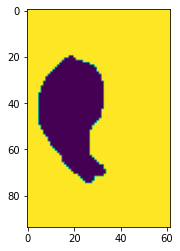

In [151]:
print(
    manual_mask[0,0],
    manual_mask[40,20]

)

1.0 0.0


1059 4769


In [165]:
trueRate = 0
for value, label in zip(values_test, classes_test):
    retVal = clf.predict_proba([value])[0]
    pred_label = np.argmax(retVal)
    #print(label, pred_label, label==pred_label)
    
    if label==pred_label:
        trueRate += 1
        
print(trueRate, trueRate / len(classes_test))

80 0.8


0 5828 0.0


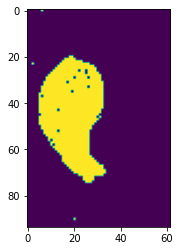

In [166]:
trues = np.zeros((sub_peaks.shape[0], sub_peaks.shape[1]))

trueEvals = 0

for x in range(0, sub_peaks.shape[0]):
    for y in range(0, sub_peaks.shape[1]):
        
        
        retVal = clf.predict_proba([ sub_peaks[x,y,:] ])[0]
        pred_label = np.argmax(retVal)
        
        if pred_label == 1:
            trues[x,y] = 1
            
print(trueEvals, sub_peaks.shape[0]*sub_peaks.shape[1], trueEvals / (sub_peaks.shape[0]*sub_peaks.shape[1]))
plt.imshow(trues)
        

2020-08-17 15:44:10,577  SpectraRegion  INFO: Processing Mass 699.4671410768037 with best existing mass 699.4671410768037


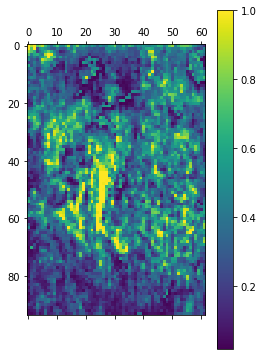

2020-08-17 15:44:10,674  SpectraRegion  INFO: Processing Mass 655.4377478775331 with best existing mass 655.4377478775331


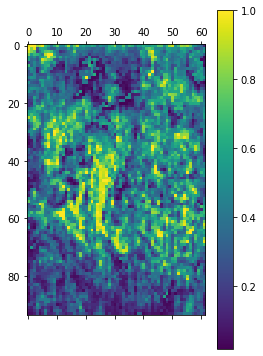

2020-08-17 15:44:10,770  SpectraRegion  INFO: Processing Mass 611.4083546782623 with best existing mass 611.4083546782623


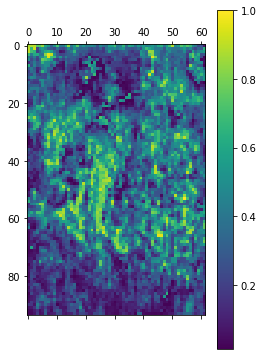

2020-08-17 15:44:10,868  SpectraRegion  INFO: Processing Mass 743.4965342760745 with best existing mass 743.4965342760745


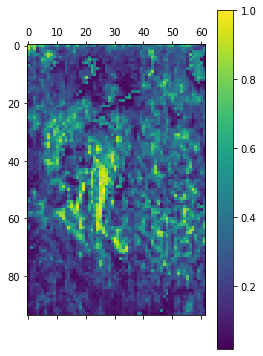

2020-08-17 15:44:10,966  SpectraRegion  INFO: Processing Mass 655.358344102602 with best existing mass 655.358344102602


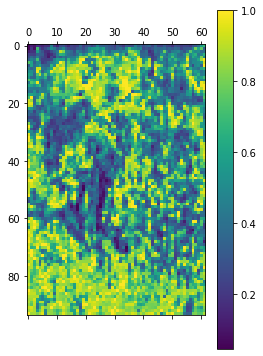

2020-08-17 15:44:11,061  SpectraRegion  INFO: Processing Mass 699.3877373018727 with best existing mass 699.3877373018727


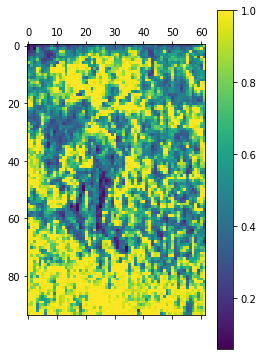

2020-08-17 15:44:11,154  SpectraRegion  INFO: Processing Mass 743.4171305011434 with best existing mass 743.4171305011434


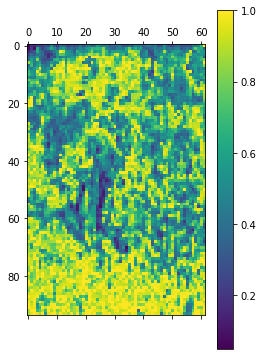

2020-08-17 15:44:11,249  SpectraRegion  INFO: Processing Mass 567.3789614789916 with best existing mass 567.3789614789916


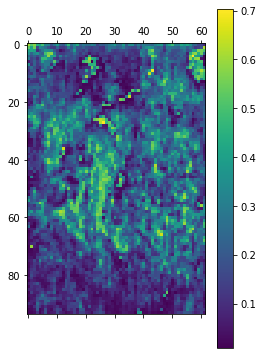

2020-08-17 15:44:11,347  SpectraRegion  INFO: Processing Mass 787.4862255878796 with best existing mass 787.4862255878796


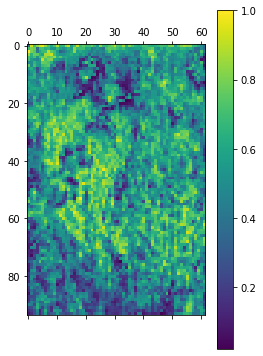

2020-08-17 15:44:11,445  SpectraRegion  INFO: Processing Mass 611.3289509033312 with best existing mass 611.3289509033312


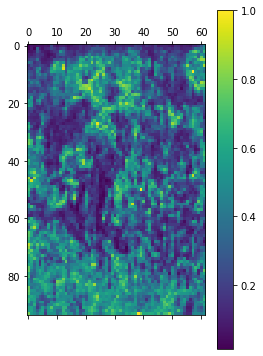

In [61]:
for x,y in fcMassesCounter.most_common(10):
    spec_subset.mass_heatmap(x)

In [ ]:
specbg_sh.calculate_similarity(mode="spectra")

In [13]:
specbg_sh.segment(method="WARD", number_of_regions=15)

2020-07-06 20:21:27,744  SpectraRegion  INFO: Calculating clusters
I0706 20:21:27.744817 140713004238656 segment.py:1038] Calculating clusters
2020-07-06 20:21:29,779  SpectraRegion  INFO: Calculating clusters done
I0706 20:21:29.779917 140713004238656 segment.py:1053] Calculating clusters done
2020-07-06 20:21:29,829  SpectraRegion  INFO: Calculating clusters saved
I0706 20:21:29.829128 140713004238656 segment.py:1071] Calculating clusters saved


array([[14,  5, 11, ...,  9, 11,  2],
       [11, 14, 11, ...,  1,  1,  1],
       [ 5, 14, 14, ...,  1,  1,  1],
       ...,
       [12, 12,  4, ...,  4, 11, 12],
       [ 9,  9, 12, ...,  4,  4,  4],
       [11,  9, 12, ...,  4,  4, 12]], dtype=int16)

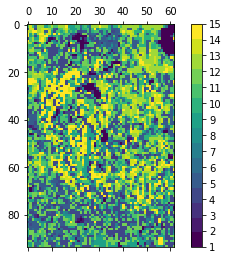

In [14]:
specbg_sh.plot_segments()

In [ ]:
sh_masses_sporig_bg.shape

In [16]:
sh_sporig_bg.shape

(94, 62, 38800)

In [174]:
spectra = sh_sporig_bg
spectra.shape

(94, 62, 38800)

In [71]:

def calculateDiffMasses( inSpectra, testPixels, testAgainstPixels, storeFCs = False):

    global_fcs = Counter()
    scalingFactor = 1000

    fcMassesCounter = Counter()
    masses2fcs = defaultdict(list)

    stdMul = 8

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])

    for (k,l) in bar(testPixels):       
        
        pixelMasses = set()

        for i in range(inSpectra.shape[0]):
            for j in range(inSpectra.shape[1]):

                if (k,l) == (i,j):
                    continue

                if not (i,j) in testAgainstPixels:
                    continue


                fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                meanFCs = np.mean(fcs)
                stdFCs = np.std(fcs)

                maxFC = meanFCs + stdMul*stdFCs
                minFC = meanFCs - stdMul*stdFCs

                if len(fcMassesCounter) > 0 and len(fcMassesCounter) % 1000 == 0:
                    print("Masses: ", len(fcMassesCounter))

                for ifc, x in enumerate(fcs):                        
                    if x < minFC or x > maxFC:
                        fcMass = imze.mzValues[ifc]
                        
                        if not fcMass in pixelMasses:
                            fcMassesCounter[fcMass] += 1
                            pixelMasses.add(fcMass)
         
    print("Found", len(fcMassesCounter), "differential masses")
        
    if storeFCs:
        bar = progressbar.ProgressBar(widgets=[
                progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
            ])

        
        for (k,l) in bar(testPixels):       

            for i in range(inSpectra.shape[0]):
                for j in range(inSpectra.shape[1]):

                    if (k,l) == (i,j):
                        continue

                    if not (i,j) in testAgainstPixels:
                        continue


                    fcs = np.log( (inSpectra[i][j]+(1.0/scalingFactor)) / (inSpectra[k][l] +(1.0/scalingFactor)) )

                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)

                    maxFC = meanFCs + stdMul*stdFCs
                    minFC = meanFCs - stdMul*stdFCs

                    for ifc, x in enumerate(fcs):

                        fcMass = imze.mzValues[ifc]

                        if fcMass in fcMassesCounter:
                            masses2fcs[fcMass].append(x)                      


    return fcMassesCounter, masses2fcs

                

In [92]:
bandPixels = calc_band_pixels(spectra)
bandPixels = set(bandPixels).difference(shapePixels)

testShape = random.sample(shapePixels, 300)

masses_de, masses_counter_de = calculateDiffMasses( sh_sporig_bg, testShape, bandPixels, storeFCs=False)

|#################################                        |  59% ETA:   0:03:45

Masses:  1000


|#########################################################| 100% Time:  0:09:06


Found 1251 differential masses


In [67]:
testShape = random.sample(shapePixels, 300)

masses_aorta, masses_counter_aorta = calculateDiffMasses( sh_sporig_bg, testShape , testShape, storeFCs=False)

|#########################################################| 100% Time:  0:08:21


Found 151 differential masses


In [78]:
tm, tmc = masses_de.most_common(1)[0]
print(tm, tmc)

1578.546333338528 300


(array([  335.,   475.,  2080.,  4698., 14544., 35102., 37720., 39325.,
        39465., 39800.]),
 array([-1.58459424, -1.26767539, -0.95075655, -0.6338377 , -0.31691885,
         0.        ,  0.31691885,  0.6338377 ,  0.95075655,  1.26767539,
         1.58459424]),
 <a list of 1 Patch objects>)

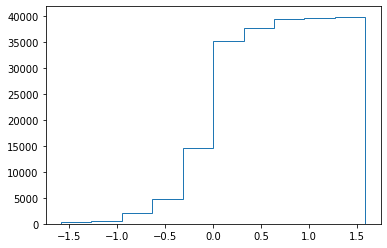

In [50]:
plt.hist(masses_counter_aorta[tm], histtype="step", cumulative=True)

In [68]:
testBg = random.sample(bgPixels, 300)

masses_bg, masses_counter_bg = calculateDiffMasses( sh_sporig_bg, testBg , testBg, storeFCs=False)

|#########################################################| 100% Time:  0:08:22


Found 186 differential masses


In [79]:
deMasses = set()

for x in masses_de:
    
    if x in masses_bg:
        continue
        
    if x in masses_aorta:
        continue
        
    deMasses.add(x)

print(len(deMasses))

102


In [80]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)]
print("mcmasses", len(mcmasses))

fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

mcmasses 886


In [70]:
masses_de.most_common(10)

[(699.4274391893382, 3410),
 (743.456832388609, 3116),
 (655.3980459900675, 3090),
 (787.4862255878796, 2820),
 (611.3686527907968, 2738),
 (655.4377478775331, 2510),
 (611.4083546782623, 2478),
 (743.4171305011434, 2194),
 (699.4671410768037, 2173),
 (787.4465237004141, 1900)]

In [81]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in deMasses])
sub_peaks_count = Counter()
for x in deMasses:
    sub_peaks_count[x] = masses_de[x]

sub_peaks_de = spectra[:,:,fcIndices]
sub_masses_de = imze.mzValues[fcIndices]

spec_subset_de = SpectraRegion(sub_peaks_de, sub_masses_de, "subset_masses")

In [82]:
spec_subset_de = SpectraRegion(sub_peaks_de, sub_masses_de, "subset_masses")

2020-08-18 16:48:44,428  SpectraRegion  INFO: Processing Mass 1574.5364427045097 with best existing mass 1574.5364427045097


1574.5364427045097 300


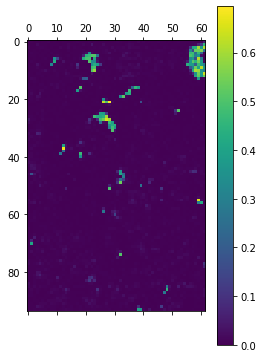

2020-08-18 16:48:44,528  SpectraRegion  INFO: Processing Mass 1578.546333338528 with best existing mass 1578.546333338528


1578.546333338528 300


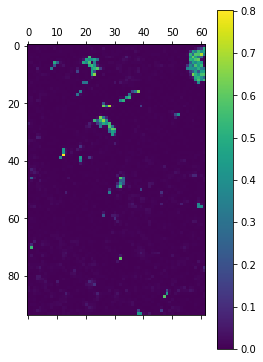

2020-08-18 16:48:44,632  SpectraRegion  INFO: Processing Mass 1656.4811384333598 with best existing mass 1656.4811384333598


1656.4811384333598 300


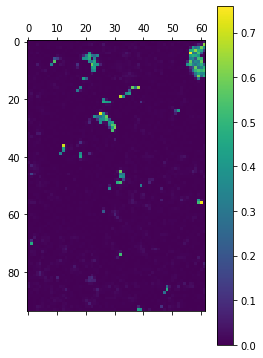

2020-08-18 16:48:44,738  SpectraRegion  INFO: Processing Mass 1264.5044034862003 with best existing mass 1264.5044034862003


1264.5044034862003 300


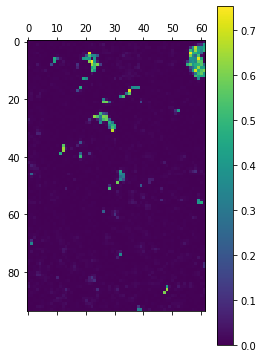

2020-08-18 16:48:44,841  SpectraRegion  INFO: Processing Mass 1755.8549627595767 with best existing mass 1755.8549627595767


1755.8549627595767 299


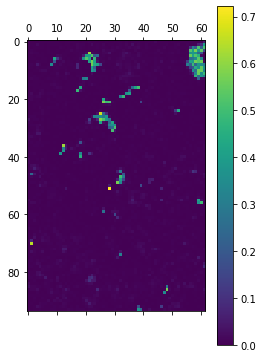

2020-08-18 16:48:44,941  SpectraRegion  INFO: Processing Mass 1812.1125372982299 with best existing mass 1812.1125372982299


1812.1125372982299 299


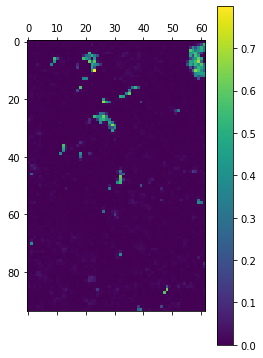

2020-08-18 16:48:45,044  SpectraRegion  INFO: Processing Mass 1455.5895878577871 with best existing mass 1455.5895878577871


1455.5895878577871 298


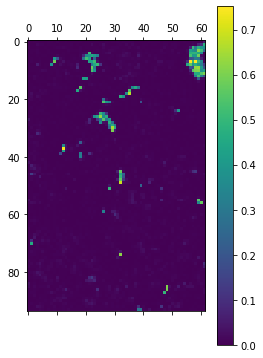

2020-08-18 16:48:45,147  SpectraRegion  INFO: Processing Mass 739.5660474169872 with best existing mass 739.5660474169872


739.5660474169872 165


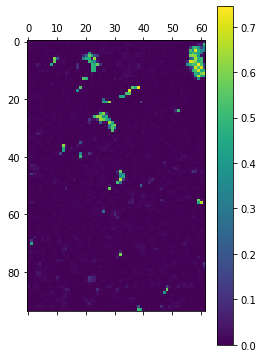

2020-08-18 16:48:45,251  SpectraRegion  INFO: Processing Mass 1302.1814946909865 with best existing mass 1302.1814946909865


1302.1814946909865 162


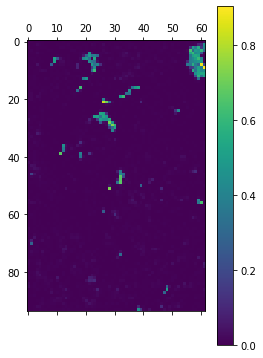

2020-08-18 16:48:45,351  SpectraRegion  INFO: Processing Mass 1762.0881590916645 with best existing mass 1762.0881590916645


1762.0881590916645 92


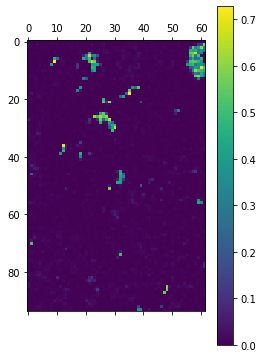

2020-08-18 16:48:45,449  SpectraRegion  INFO: Processing Mass 1719.0910149664976 with best existing mass 1719.0910149664976


1719.0910149664976 87


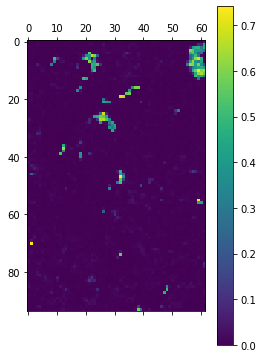

2020-08-18 16:48:45,558  SpectraRegion  INFO: Processing Mass 1437.5649309484374 with best existing mass 1437.5649309484374


1437.5649309484374 68


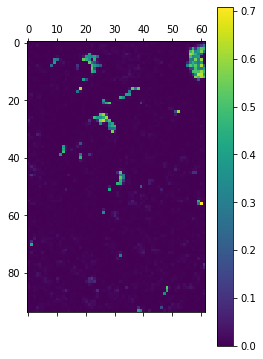

2020-08-18 16:48:45,657  SpectraRegion  INFO: Processing Mass 1395.7191415597708 with best existing mass 1395.7191415597708


1395.7191415597708 46


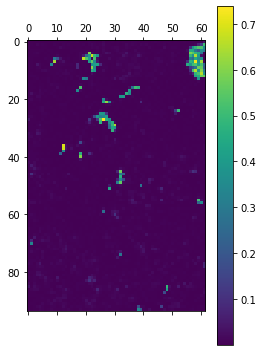

2020-08-18 16:48:45,755  SpectraRegion  INFO: Processing Mass 1534.5963439141883 with best existing mass 1534.5963439141883


1534.5963439141883 45


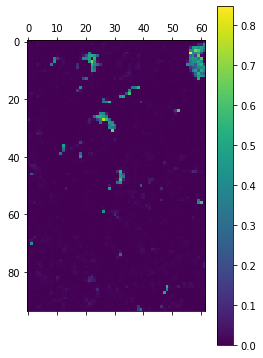

2020-08-18 16:48:45,862  SpectraRegion  INFO: Processing Mass 960.1100322879961 with best existing mass 960.1100322879961


960.1100322879961 40


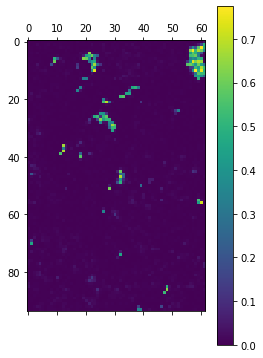

In [84]:
for x,y in sub_peaks_count.most_common(15):
    print(x,y)
    spec_subset_de.mass_heatmap(x)

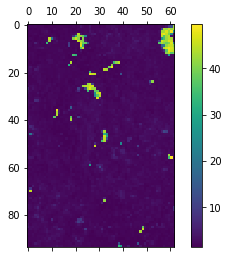

In [76]:
spec_subset_de.plot_tic()

In [21]:
len(fcMassesCounter)

719

In [23]:
mcmasses = [x[0] for x in fcMassesCounter.most_common(10000)]
len(mcmasses)

719

In [24]:
fcIndices = sorted([i for i in range(0, len(imze.mzValues)) if imze.mzValues[i] in mcmasses])

In [25]:
sub_peaks = spectra[:,:,fcIndices]
sub_masses = imze.mzValues[fcIndices]

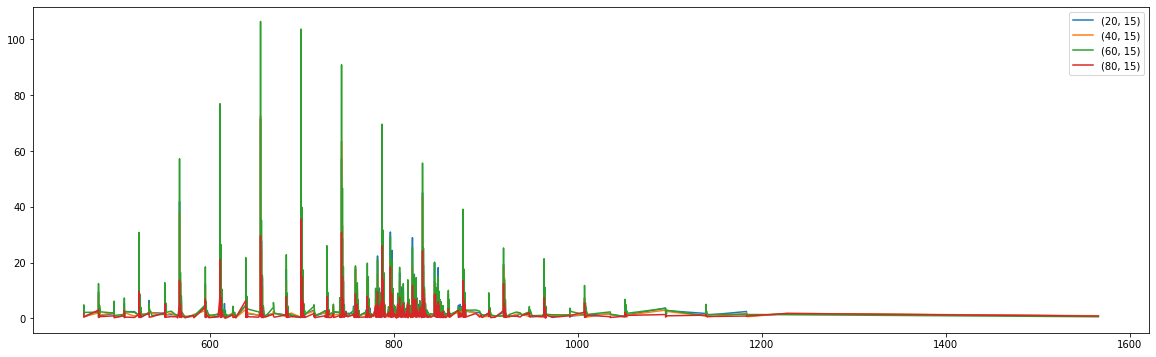

In [199]:
plot_coords(sub_peaks, [(20,15), (40,15), (60,15), (80,15)], range(0,len(sub_masses)), sub_masses)

In [198]:
sub_masses

array([ 463.28061254,  463.32031443,  463.36001632,  479.24077131,
        479.28047319,  479.32017508,  479.35987697,  479.39957886,
        480.23331849,  480.27302038,  480.31272227,  481.30526945,
        496.31258292,  496.3522848 ,  496.39198669,  496.43168858,
        507.27030386,  507.31000574,  507.34970763,  507.38940952,
        507.42911141,  508.34225482,  518.34713046,  523.23046262,
        523.2701645 ,  523.30986639,  523.34956828,  523.38927017,
        523.42897205,  524.26271169,  524.30241358,  524.34211547,
        524.38181735,  524.42151924,  524.46122113,  525.29496077,
        525.33466265,  525.41406643,  534.26758733,  534.30728922,
        534.34699111,  537.32463267,  551.29969706,  551.33939894,
        551.37910083,  551.41880272,  551.45850461,  552.33194613,
        552.37164802,  552.4113499 ,  558.32693114,  564.32191614,
        565.39386711,  567.25985582,  567.2995577 ,  567.33925959,
        567.37896148,  567.41866337,  567.45836525,  567.49806

In [28]:
def calc_similarity( mat ):

    #mat = np.array(sub_peaks, copy=True)

    bar = progressbar.ProgressBar(widgets=[
            progressbar.Bar(), ' ', progressbar.Percentage(), ' ', progressbar.AdaptiveETA()
        ])    
    elems = mat.shape[0]*mat.shape[1]

    result = np.zeros((elems, elems))

    meanMat = np.zeros((elems, elems))
    stdMat = np.zeros((elems, elems))

    print("Calculating cosine similarity Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    for i in bar(range(0, mat.shape[0])):
        for j in range(0, mat.shape[1]):
            idxI = i*mat.shape[1] + j
            matIJ = mat[i,j,:]

            for k in range(0, mat.shape[0]):
                for l in range(0, mat.shape[1]):
                    idxJ = k*mat.shape[1] + l
                    matKL = mat[k,l,:]

                    if idxJ == idxI:
                        result[idxI, idxJ] = len(matIJ)
                        continue

                    if idxJ < idxJ:
                        continue

                    fcs = np.log((matIJ+0.1) / (matKL+0.1))
                    #fcs = sorted(fcs)

                    meanFCs = np.mean(fcs)
                    stdFCs = np.std(fcs)

                    meanMat[idxI, idxJ] = meanFCs
                    stdMat[idxI, idxJ] = stdFCs

                    maxFC = meanFCs + 2*stdFCs
                    minFC = meanFCs - 2*stdFCs
                    
                    #print(min(fcs), max(fcs), minFC, maxFC)

                    kfcs = fcs[fcs <= maxFC]
                    kfcs = kfcs[minFC <= kfcs]

                    sims = len(kfcs)

                    result[idxI, idxJ] = sims
                    result[idxJ, idxI] = sims

    print("Calculating cosine similarity End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))

    return result, meanMat, stdMat
            
            

In [207]:
sub_peaks.shape

(94, 62, 719)

In [29]:
subpeak_sim, subpeak_mean, subpeak_std = calc_similarity(sub_peaks)

|                                                         | N/A% ETA:  --:--:--

Calculating cosine similarity Start 05/08/2020 21:23:13


|#########################################################| 100% Time:  0:23:07


Calculating cosine similarity End 05/08/2020 21:46:20


In [33]:
import pickle

In [34]:
with open("subpeak_sim.pickle", 'wb') as fout:
    pickle.dump( (sub_peaks, subpeak_sim, subpeak_mean, subpeak_std), file=fout)

In [25]:
with open("subpeak_sim.pickle", "rb") as fin:
    (sub_peaks, subpeak_sim, subpeak_mean, subpeak_std) = pickle.load(fin)

In [221]:
orig_subpeak_sim = np.array(subpeak_sim, copy=True)

In [36]:
np.max(subpeak_sim)

719.0

In [37]:
subpeak_sim_norm = subpeak_sim  /np.max(subpeak_sim)

In [38]:
np.max(subpeak_sim_norm)

1.0

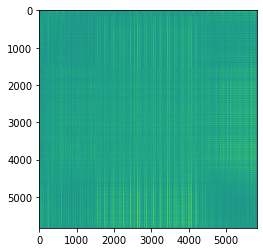

In [35]:
plt.imshow(subpeak_sim)

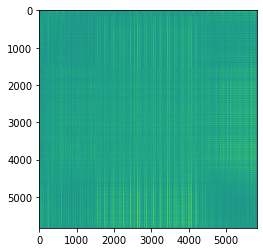

In [39]:
plt.imshow(subpeak_sim_norm)

In [200]:
spec_std = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [208]:
spec_std.calculate_similarity(mode="spectra")

2020-08-17 23:34:40,791  SpectraRegion  INFO: Creating C++ obj
2020-08-17 23:34:40,792  SpectraRegion  INFO: 886 (94, 62, 886)
2020-08-17 23:34:40,792  SpectraRegion  INFO: dimensions 886
2020-08-17 23:34:40,793  SpectraRegion  INFO: input dimensions (94, 62, 886)
2020-08-17 23:34:40,794  SpectraRegion  INFO: Switching to dot mode
2020-08-17 23:34:40,801  SpectraRegion  INFO: Starting calc similarity c++


886


2020-08-17 23:34:52,180  SpectraRegion  INFO: outclust dimensions (5828, 5828)


array([[0.99999994, 0.85200185, 0.9234092 , ..., 0.34745678, 0.42575976,
        0.2952746 ],
       [0.85200185, 1.0000001 , 0.9814296 , ..., 0.60150945, 0.68964714,
        0.52542853],
       [0.9234092 , 0.9814296 , 1.        , ..., 0.53609645, 0.62285614,
        0.4621586 ],
       ...,
       [0.34745678, 0.60150945, 0.53609645, ..., 0.99999994, 0.98580456,
        0.9810783 ],
       [0.42575976, 0.68964714, 0.62285614, ..., 0.98580456, 0.9999999 ,
        0.9598223 ],
       [0.2952746 , 0.52542853, 0.4621586 , ..., 0.9810783 , 0.9598223 ,
        1.0000001 ]], dtype=float32)

In [41]:
spec_std.spectra_similarity = subpeak_sim_norm

In [215]:
spec_std.segment(method="WPGMA", number_of_regions=5)

2020-08-17 23:42:55,206  SpectraRegion  INFO: Calculating clusters
2020-08-17 23:42:56,168  SpectraRegion  INFO: Calculating clusters done
2020-08-17 23:42:56,179  SpectraRegion  INFO: Calculating clusters saved


array([[2, 2, 2, ..., 3, 3, 5],
       [2, 3, 2, ..., 5, 4, 4],
       [3, 3, 3, ..., 4, 4, 4],
       ...,
       [5, 5, 5, ..., 3, 3, 5],
       [5, 5, 5, ..., 5, 3, 5],
       [5, 5, 5, ..., 5, 5, 5]], dtype=int16)

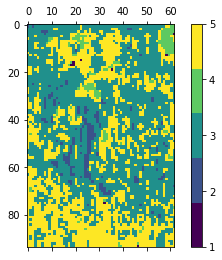

In [216]:
spec_std.plot_segments()

2020-08-17 23:44:08,426  SpectraRegion  INFO: Calculating clusters
2020-08-17 23:44:08,443  SpectraRegion  INFO: UMAP reduction


Elem Matrix (5828, 886)


2020-08-17 23:44:17,661  SpectraRegion  INFO: HDBSCAN reduction
2020-08-17 23:44:17,738  SpectraRegion  INFO: Calculating clusters done
2020-08-17 23:44:17,743  SpectraRegion  INFO: Calculating clusters saved


Dimred Shape (5828, 2)
Unassigned (0, 2)


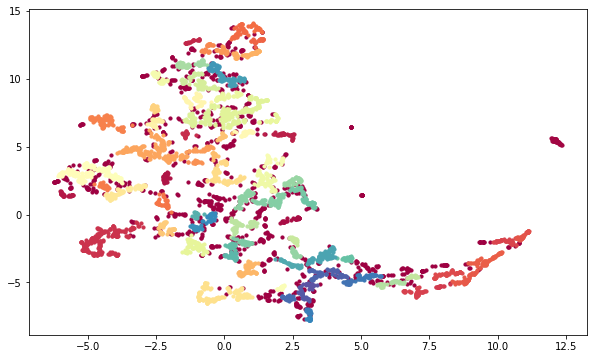

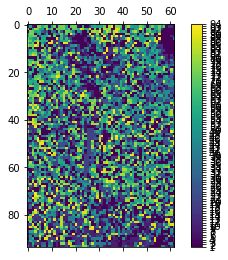

In [218]:
spec_std.segment(method="UMAP_DBSCAN",n_neighbors=5, min_samples=10, min_cluster_size=20)

mpl.rcParams['figure.figsize'] = (10,6)
spec_std.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

spec_std.plot_segments()

In [40]:
import seaborn as sns
import pandas as pd

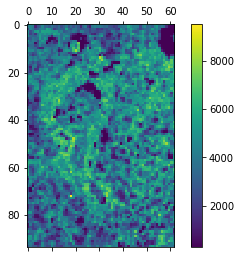

In [220]:
res = spec_std.plot_tic()

In [221]:
res

In [77]:
pdarr = pd.DataFrame(spec_std.elem_matrix / np.max(spec_std.elem_matrix))

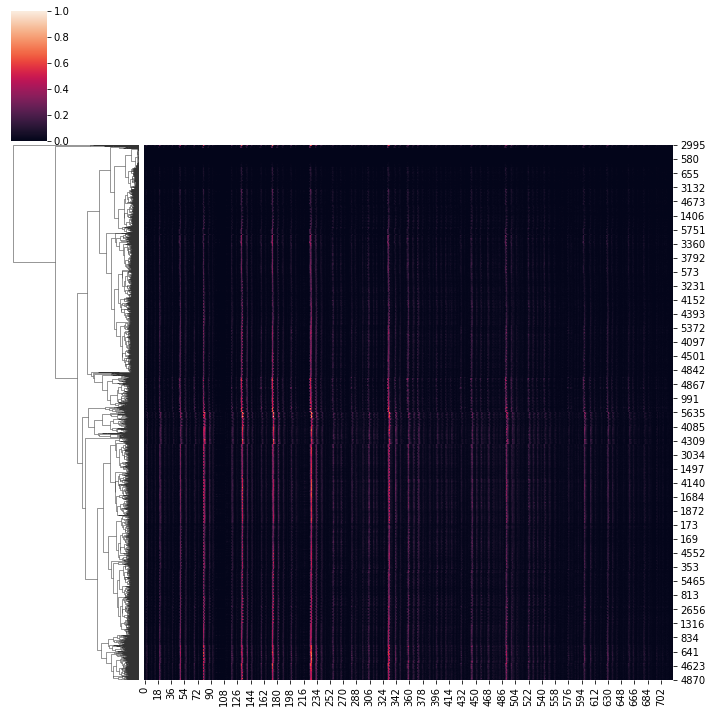

In [78]:
sns.clustermap(pdarr, col_cluster=False, row_cluster=True)

In [182]:
spec_subset = SpectraRegion(sub_peaks, sub_masses, "subset_masses")

In [186]:
spec_subset.calculate_similarity(mode="spectra_log")

2020-07-07 01:34:30,995  SpectraRegion  INFO: Creating C++ obj
I0707 01:34:30.995791 140209083385664 segment.py:811] Creating C++ obj
2020-07-07 01:34:30,998  SpectraRegion  INFO: 719 (94, 62, 719)
I0707 01:34:30.998478 140209083385664 segment.py:812] 719 (94, 62, 719)
2020-07-07 01:34:31,000  SpectraRegion  INFO: dimensions 719
I0707 01:34:31.000407 140209083385664 segment.py:822] dimensions 719
2020-07-07 01:34:31,002  SpectraRegion  INFO: input dimensions (94, 62, 719)
I0707 01:34:31.002395 140209083385664 segment.py:823] input dimensions (94, 62, 719)
2020-07-07 01:34:31,004  SpectraRegion  INFO: Switching to dot mode
I0707 01:34:31.004238 140209083385664 segment.py:826] Switching to dot mode
2020-07-07 01:34:31,048  SpectraRegion  INFO: Starting calc similarity c++
I0707 01:34:31.048956 140209083385664 segment.py:832] Starting calc similarity c++


719


2020-07-07 01:34:36,601  SpectraRegion  INFO: outclust dimensions (5828, 5828)
I0707 01:34:36.601086 140209083385664 segment.py:837] outclust dimensions (5828, 5828)
2020-07-07 01:34:36,604  SpectraRegion  INFO: Calculating spectra similarity
I0707 01:34:36.604266 140209083385664 segment.py:869] Calculating spectra similarity
2020-07-07 01:34:37,487  SpectraRegion  INFO: Calculating spectra similarity done
I0707 01:34:37.487196 140209083385664 segment.py:873] Calculating spectra similarity done


array([[1.        , 0.8886914 , 0.94358313, ..., 0.42837337, 0.5097377 ,
        0.37068847],
       [0.8886914 , 1.        , 0.98660064, ..., 0.67860025, 0.75591606,
        0.607904  ],
       [0.94358313, 0.98660064, 1.        , ..., 0.6182174 , 0.6974949 ,
        0.54653513],
       ...,
       [0.42837337, 0.67860025, 0.6182174 , ..., 1.        , 0.98987204,
        0.98647416],
       [0.5097377 , 0.75591606, 0.6974949 , ..., 0.98987204, 1.        ,
        0.9708533 ],
       [0.37068847, 0.607904  , 0.54653513, ..., 0.98647416, 0.9708533 ,
        1.        ]], dtype=float32)

In [194]:
spec_subset.segment(method="CENTROID", number_of_regions=15)

2020-07-07 01:35:53,735  SpectraRegion  INFO: Calculating clusters
I0707 01:35:53.735009 140209083385664 segment.py:1061] Calculating clusters
2020-07-07 01:35:56,930  SpectraRegion  INFO: Calculating clusters done
I0707 01:35:56.930651 140209083385664 segment.py:1082] Calculating clusters done
2020-07-07 01:35:56,949  SpectraRegion  INFO: Calculating clusters saved
I0707 01:35:56.949959 140209083385664 segment.py:1100] Calculating clusters saved


array([[ 9, 12,  9, ..., 13, 13, 11],
       [ 9, 12,  9, ..., 11,  7,  4],
       [12, 12, 12, ...,  4,  4,  4],
       ...,
       [11, 11, 13, ..., 13, 13, 11],
       [10, 11, 11, ..., 13, 13, 13],
       [10, 11, 11, ..., 13, 13, 11]], dtype=int16)

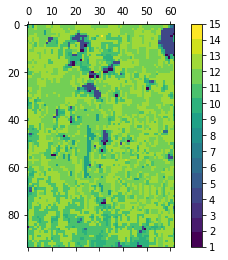

In [195]:
spec_subset.plot_segments()

In [191]:
spec_subset.filter_clusters(method='remove_singleton')
spec_subset.filter_clusters(method='merge_background')
spec_subset.filter_clusters(method='remove_islands')

2020-07-07 01:35:06,499  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20}
I0707 01:35:06.499232 140209083385664 segment.py:1189] Assigning clusters to background: {1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

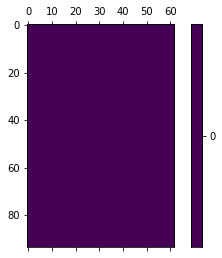

In [178]:
spec_subset.plot_segments()

In [33]:
spec_subset.segment(method="UMAP_DBSCAN", n_neighbors=5, min_samples=10, min_cluster_size=20)

NameError: name 'spec_subset' is not defined

Dimred Shape (5828, 2)
Unassigned (0, 2)


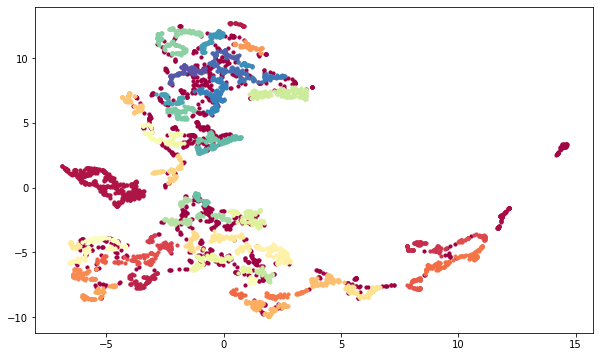

In [168]:
spec_subset.segment(method="UMAP_DBSCAN", n_neighbors=5, min_samples=10, min_cluster_size=20)

mpl.rcParams['figure.figsize'] = (10,6)
spec_subset.vis_umap(legend=False)
mpl.rcParams['figure.figsize'] = (6,4)

spec_subset.plot_segments()

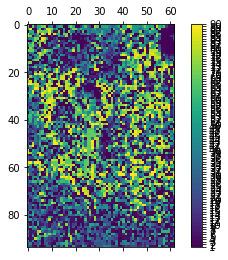

In [169]:
spec_subset.plot_segments()

In [57]:
spec_subset.filter_clusters(method='remove_singleton')
spec_subset.filter_clusters(method='merge_background')
spec_subset.filter_clusters(method='remove_islands')

2020-07-06 22:56:29,607  SpectraRegion  INFO: Assigning clusters to background: {1, 2, 3, 36, 5, 6, 7, 4, 10, 11, 13, 15, 16, 18, 25, 29}
I0706 22:56:29.607889 140209083385664 segment.py:1160] Assigning clusters to background: {1, 2, 3, 36, 5, 6, 7, 4, 10, 11, 13, 15, 16, 18, 25, 29}


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

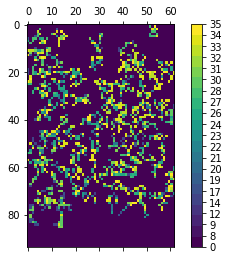

In [58]:
spec_subset.plot_segments()

In [ ]:
def calc_dot_sim( mat ):
    
    bar = progressbar.ProgressBar()
    
    elems = mat.shape[0]*mat.shape[1]
    
    result = np.zeros((elems, elems))
    mats = np.array(mat, copy=True)
    
    def normalized(a, axis=-1, order=2):
        l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
        l2[l2==0] = 1
        return a / np.expand_dims(l2, axis)
    
    print("Normalizing Matrix Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    mats = normalized(mat,2)
    print("Normalizing Matrix End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
        
    print("Calculating cosine similarity Start", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    for i in bar(range(0, mats.shape[0])):
        for j in range(0, mats.shape[1]):
            idxI = i*mats.shape[1] + j
            
            for k in range(0, mats.shape[0]):
                for l in range(0, mat.shape[1]):
                    idxJ = k*mats.shape[1] + l
                    
                    if idxJ == idxI:
                        result[idxI, idxJ] = 1
                        continue
                    
                    if idxJ < idxJ:
                        continue
                        
                    cosSim = np.dot(mats[i,j,:], mats[k,j,:])
                    result[idxI, idxJ] = cosSim
                    result[idxJ, idxJ] = cosSim
                    
    print("Calculating cosine similarity End", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
                    
    return result
            
            

In [ ]:
npcos = calc_dot_sim( sh_array )

In [15]:
spec_sh.segment(method="WARD", number_of_regions=15)

NameError: name 'spec_sh' is not defined

In [ ]:
spec_sh.plot_segments()

In [ ]:
spec_sh.filter_clusters(method='remove_singleton')
#spec_sh.filter_clusters(method='merge_background')
#spec_sh.filter_clusters(method='remove_islands')

In [ ]:
spec_sh.plot_segments()

In [ ]:
plt.imshow(sh_array[:,:,100])

In [ ]:
plt.figure(figsize=(20, 6))
mzvals = range(0,len(refSpec))
plt.plot(mzvals, refSpec, label="30,1")

for idx in i2sp:
    plt.plot(mzvals, i2sp[idx], label="spec {} shifted".format(idx))


plt.legend()

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(imze.mzValues, spec.region_array[40,40])

In [ ]:
spec32, spec32Idx, origCoords = imze.get_pixel_spectrum(2, (3,2))

In [ ]:
spec32Idx, origCoords

In [ ]:
ridx = imze.get_region_index_array(2)

In [ ]:
ridx[0:5,0:5]

In [ ]:
[x for x in imze.parser.coordinates if x[0] == 693 and x[1] == 317]

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(imze.mzValues, spec32)

In [ ]:
spec.calculate_similarity(mode="spectra_log_dist")

In [ ]:
import progressbar

bar = progressbar.Bar()

for x in bar(range(0,10)):
    sleep(1)